In [27]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../..'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Getting Started with Equivariant Representations

Our general approach to equivariance is centered around the idea of _representations_, a prescription of how a group element acts on a given vector space.

Given a vector space $V$ and a group $G$, elements of the group $g\in G$ can act on a vector $v\in V$ by the representation matrix $v\mapsto \rho(g)v$. The vector space $V$ and the matrix $\rho$ are often referred to interchangeably as the representation.

For example with the cyclic translation group $\mathbb{Z}_4$, we implement a (faithful) base representation $V$ which cyclicly translates the elements. Sampling an arbitrary transformation, we have

In [92]:
from emlp.reps import V,sparsify_basis
from emlp.groups import Z,S,SO,O,O13,SO13,RubiksCube, noise2samples
import jax.numpy as jnp
import numpy as np

In [59]:
G.discrete_generators[0].shape

(4, 4)

In [84]:
h_dense = jnp.stack([hi@jnp.eye(G.d) for hi in G.discrete_generators]) 

In [104]:
N = 1
A_dense = jnp.stack([Ai@jnp.eye(G.d) for Ai in G.lie_algebra]) if len(G.lie_algebra) else jnp.zeros((0,G.d,G.d))
h_dense = jnp.stack([hi@jnp.eye(G.d) for hi in G.discrete_generators]) if len(G.discrete_generators) else jnp.zeros((0,G.d,G.d))
z = np.random.randn(N,A_dense.shape[0])
if G.z_scale is not None:
    z*= G.z_scale
k = np.random.randint(-5,5,size=(N,h_dense.shape[0],3))
jax_seed= np.random.randint(100)

noise2samples(z,k,A_dense,h_dense,jax_seed)

Array([[[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]]], dtype=float32)

In [91]:
k = np.random.randint(-5,5,size=(1,h_dense.shape[0],3))
jax_seed=  np.random.randint(100)
noise2samples()

array([[[-5, -4, -5]]])

In [74]:
len(G.lie_algebra)

0

In [69]:
G=Z(4)
rep = V(G)
v = np.random.randn(rep.size())
g = G.sample()
print(f"𝜌(g) =\n{rep.rho(g)}")
print(f"v = {v}")
print(f"𝜌(g)v = {rep.rho(g)@v:}")

𝜌(g) =
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
v = [-0.14245027  0.06231451 -0.82636948  0.53054457]
𝜌(g)v = [ 0.5305446  -0.14245027  0.06231451 -0.82636946]


The symmetric subspace of the representation is the space of solutions to the constraint $\forall g\in G: \ \ \rho(g)v=v$.
For any representation, you can get the basis $Q \in \mathbb{R}^{n\times r}$ for this symmetric subspace with `rep.equivariant_basis()` and the matrix $P=QQ^T$ which projects to this subspace with `rep.equivariant_projector()`.

For example, we can find invariant vectors of the cyclic translation group $\mathbb{Z}_n$ which is just the constant $\vec{1}$ scaled to have unit norm.

In [30]:
V(Z(5)).equivariant_basis()

Array([[0.44721356],
       [0.44721374],
       [0.44721374],
       [0.44721356],
       [0.44721347]], dtype=float32)

## The Representation Type System

Each implemented group comes with a faithful 'base' representation $V$. Because faithful representations are one-to-one, we can build any representation by transforming this base representation.

We provide several operators to transform and construct representations in different ways built and later go on to show how to do this more generally. In our type system, representations can be combined with the direct sum $\rho_a \oplus\rho_b$ operator, the tensor product $\rho_a\otimes\rho_b$, the dual $\rho^*$ and these operators are implemented as the python operators `+`, `*`, and `.T`.

In [31]:
V+V,  V*V,  V.T

((V+V), V⊗V, V*)

We can combine and use these operators interchangeably:

In [32]:
(V+V.T)*(V*V.T+V)

(V+V*)⊗(V⊗V*+V)

We use the shorthand $cV$ to mean $V\oplus V\oplus...\oplus V$ and $V^c = V\otimes V\otimes...\otimes V$. Note that this differs from the common notation where $V^c$ denotes the cartesian products the set (like with $\mathbb{R}^c$) which would be the same as $cV$ in this notation. Being more formal we could distinguish the two by denoting $V^{\otimes c}=V\otimes V\otimes...\otimes V$ but to stay consistent with the python interface, we will not.

In [33]:
5*V*2

(V+V+V+V+V+V+V+V+V+V)

In [34]:
2*V**3

(V⊗V⊗V+V⊗V⊗V)

When a particular symmetry group is specified, the representation can be collapsed down to a more compact form:

In [35]:
G=O(4)
2*V(G)**3

2V³

In [36]:
(2*V**3)(G)

2V³

Although for groups like the Lorentz group $SO(1,3)$ with non orthogonal representations, a distinction needs to be made between the representation and it's dual. In both cases the representation is converted down to a canonical form (but the ordering you gave is preserved as a permutation).

In [37]:
V(SO(3)).T+V(SO(3))

2V

In [38]:
V(SO13()).T+V(SO13())

V+V*

Linear maps from $V_1\rightarrow V_2$ have the type $V_2\otimes V_1^*$. The `V>>W` is shorthand for `W*V.T` and produces linear maps from `V` to `W`.

Imposing (cyclic) Translation Equivariance $G=\mathbb{Z}_n$ on linear maps $V\rightarrow V$ yields circular convolutions (circulant matrices) which can be expressed as a linear combination of $n$ basis elements of size $n\times n$.

## Exploring and Visualizing Equivariant Bases

In [39]:
G = Z(6)
repin = V(G)
repout = V(G)
conv_basis = (repin>>repout).equivariant_basis()
print(f"Conv basis has shape {conv_basis.shape}")

Conv basis has shape (36, 6)


While we provide an orthogonal basis, these bases are not always easy to make sense of as an array of numbers (any rotation of an orthogonal basis is still an orthogonal basis)

In [40]:
conv_basis[:,0]

Array([-0.1546345 ,  0.26888803, -0.16306758,  0.07573703, -0.19462179,
        0.01579757,  0.01579724, -0.15463413,  0.26888806, -0.16306749,
        0.07573721, -0.19462138, -0.19462171,  0.01579699, -0.15463421,
        0.26888776, -0.1630673 ,  0.07573732,  0.07573705, -0.19462131,
        0.01579705, -0.15463448,  0.26888755, -0.1630673 , -0.16306736,
        0.0757368 , -0.19462158,  0.01579736, -0.1546349 ,  0.2688875 ,
        0.2688878 , -0.16306758,  0.07573678, -0.19462138,  0.01579751,
       -0.1546349 ], dtype=float32)

To more easily visualize the result, we can define the following function which projects a random vector and then plots components with the same values as different colors, arranged in a desired shape.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def vis_basis(basis,shape,cluster=True):
    Q=basis@jnp.eye(basis.shape[-1]) # convert to a dense matrix if necessary
    v = np.random.randn(Q.shape[0])  # sample random vector
    v = Q@(Q.T@v)                    # project onto equivariant subspace
    if cluster: # cluster nearby values for better color separation in plot
        v = KMeans(n_clusters=Q.shape[-1]).fit(v.reshape(-1,1)).labels_
    plt.imshow(v.reshape(shape))
    plt.axis('off')
    
    return v

def vis(repin,repout,cluster=True):
    Q = (repin>>repout).equivariant_basis() # compute the equivariant basis
    vis_basis(Q,(repout.size(),repin.size()),cluster) # visualize it

Our convolutional basis is the familiar (circulant) convolution matrix.

/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


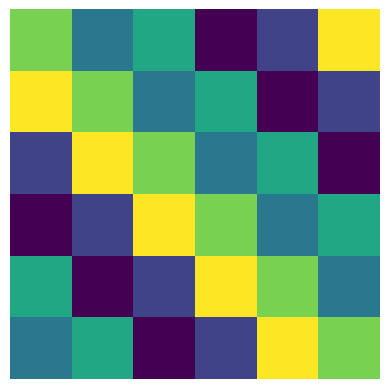

In [46]:
v = vis_basis(conv_basis,(repin.size(),repout.size()))

In [50]:
shape = (repin.size(),repout.size())
v.reshape(shape)

array([[4, 2, 3, 0, 1, 5],
       [5, 4, 2, 3, 0, 1],
       [1, 5, 4, 2, 3, 0],
       [0, 1, 5, 4, 2, 3],
       [3, 0, 1, 5, 4, 2],
       [2, 3, 0, 1, 5, 4]], dtype=int32)

In [47]:
v

array([4, 2, 3, 0, 1, 5, 5, 4, 2, 3, 0, 1, 1, 5, 4, 2, 3, 0, 0, 1, 5, 4,
       2, 3, 3, 0, 1, 5, 4, 2, 2, 3, 0, 1, 5, 4], dtype=int32)

2D translation equivariange $G=\mathbb{Z}_n\times \mathbb{Z}_n$ yields 2D convolutions (bicurculant matrices)

/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


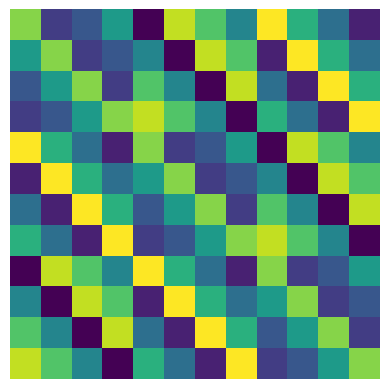

In [19]:
G = Z(3)*Z(4) #[Not recommended way of building product groups, there is a faster way shown in section 5]
repin = V(G)
repout = V(G)
vis(repin,repout)

How about the permutation group $G=S_n$, where the vector space $V$ represents a set of elements? In deep sets it was shown there are only two basis elements for equivariant linear maps $V\rightarrow V$.

/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


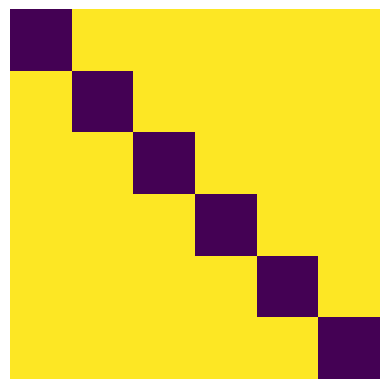

In [20]:
repin = V(S(6))
repout = V(S(6))
vis(repin,repout)

What about graphs, which are composed both of sets as well as adjacency matrices or graph laplacians? These matrices are examples of objects from $V\otimes V$ with $G=S_n$, and in Invariant and Equivariant Graph Networks () it was shown through a challenging proof that there are at most 15 basis elements which were derived analytically. We can solve for them here:

Basis matrix of shape (1296, 15)


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


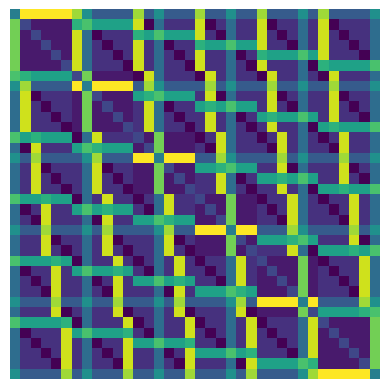

In [21]:
repin = V(S(6))**2
repout = V(S(6))**2
vis(repin,repout)
print(f"Basis matrix of shape {(repin>>repout).equivariant_basis().shape}")

How about the continuous $2D$ rotation group $SO(3)$? It's well known that the only equivariant object for the vector space $V^{\otimes 3}$ is the Levi-Civita symbol $\epsilon_{ijk}$. Since the values are both $0$, positive, and negative (leading to more than `Q.shape[-1]` clusters) we disable the clustering.

Basis matrix of shape (27, 1)


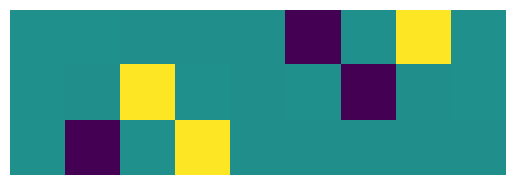

In [22]:
W = V(SO(3))
repin = W**2
repout = W
Q = (repin>>repout).equivariant_basis()
print(f"Basis matrix of shape {Q.shape}")
vis(repin,repout,cluster=False)

In [23]:
print(sparsify_basis(Q).reshape(3,3,3))

sparsifying basis: 100%|██████████| 3000/3000 [00:00<00:00, 8011.26it/s]

[[[ 0.  0.  0.]
  [ 0.  0.  1.]
  [ 0. -1.  0.]]

 [[ 0.  0. -1.]
  [ 0.  0.  0.]
  [ 1.  0.  0.]]

 [[ 0.  1.  0.]
  [-1.  0.  0.]
  [ 0.  0.  0.]]]


We can also solve for very high dimensional representations which we automatically switch to using the automated iterative Krylov subspace method

/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


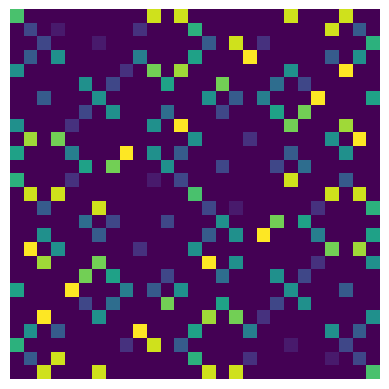

In [24]:
vis(W**3,W**3)

Krylov Solving for Equivariant Subspace r<=160: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s] 
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


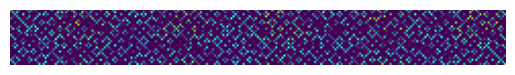

In [25]:
vis(W**5,W**3)

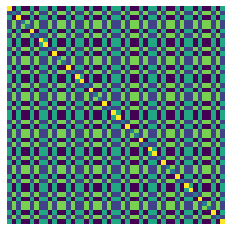

In [23]:
vis(V(RubiksCube()),V(RubiksCube()))

## Composite Representations and Lazy Matrices

How about maps from graphs to sets? Lets say a graph consists of one node feature and one edge feature which can be represented with the $\oplus$ operator.

(252, 7)


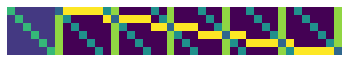

In [24]:
W = V(S(6))
repin = W+W**2 # (one set feature and one edge feature)
repout = W     # (one set feature)
vis(repin,repout)
print(f"Basis matrix of shape {(repin>>repout).equivariant_basis().shape}")

Representations that have many copies or multiplicity of a given representation type, such as for the many channels in a neural network, are simply examples of the $\oplus$ operator (`+` in python). The `rep.equivariant_basis()` and `rep.equivariant_projector()` can return lazy matrices $Q$ and $P=QQ^T$ when the representations are composite (or when the representation is specified lazily). These Lazy matrices are modeled after [scipy LinearOperators](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html). By exploiting structure in the matrices via fast matrix vector multiplies (MVMs), it can be possible to work with extremely large matrices.

For example with a more realistically sized layer with 100 global constants, 100 set feature channels, and 20 edge feature channels ($100V^0+100V^1+20V^2$) we have

In [25]:
W = V(S(6))
repin = 100*W**0 + 100*W+20*W**2
repout = repin
rep_map = repin>>repout
print(f"{rep_map}, of size {rep_map.size()}")

Q = rep_map.equivariant_basis()
print(f"Basis matrix of shape {Q.shape}")

10000V⁰+20000V+14000V²+4000V³+400V⁴, of size 2016400
Basis matrix of shape (2016400, 84000)


Unfortunately the larger matrices are harder to visualize as for the matrix above we need 84000 different colors! We are happy to field suggestions for visualizing very large bases.

(-0.5, 1419.5, 1419.5, -0.5)

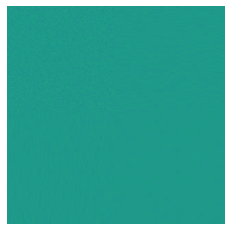

In [26]:
P =rep_map.equivariant_projector()
v = np.random.randn(P.shape[-1])
v = P@v
plt.imshow(v.reshape(repout.size(),repin.size()))
plt.axis('off');